In [6]:
import numpy as np;
import matplotlib as mpl;
mpl.use("Agg");
import matplotlib.pyplot as plt
from neural_network import generate_data;
%matplotlib inline
REG_LAMBDA = 0.01;
LEAKY_RELU_LAMBDA = 0.01;

def tanh(z): return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z));
def diff_tanh(z): return 1.0 - tanh(z) * tanh(z);
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z));
def diff_sigmoid(z): return sigmoid(z) * (1.0 - sigmoid(z)); 
def relu(z): return (-LEAKY_RELU_LAMBDA * z * (z < 0.0)) + (z * (z >= 0.0))
diff_relu = np.vectorize(lambda x: -LEAKY_RELU_LAMBDA if x < 0.0 else 1.0);

act_fun = tanh;
diff_act_fun = diff_tanh;

def to_one_hot(y):
	yhot = np.zeros((y.shape[0], 2));
	yhot[np.arange(y.shape[0]), y] = 1;
	return yhot;

# def act_fun(z):
	# return z;

def gen_data():
    from sklearn import datasets;
    np.random.seed(1717)
    X, y = datasets.make_circles(300, noise=0.10)
    return X, y

def make_net(in_dim, hidden_dim_list, out_dim):
    net = {};
    dim_list = [in_dim] + hidden_dim_list + [out_dim];

    net["w"] = [];
    net["b"] = [];
    for i in range(len(dim_list)):
        if i == len(dim_list) - 1:
            continue;

        net["w"].append(np.random.randn(dim_list[i], dim_list[i + 1]) / np.sqrt(dim_list[i]));
        net["b"].append(np.zeros((1, dim_list[i + 1])));

    return net;

def feedforward(net, X):
    net["z"] = []
    net["a"] = []
    orig_in = X;
    for w, b in zip(net["w"], net["b"]):
        bias_in = np.hstack([np.ones((orig_in.shape[0], 1)), orig_in]);
        bias_w = np.vstack([b, w]);

        z = np.dot(bias_in, bias_w);
        out = act_fun(z);
        net["z"].append(z);
        net["a"].append(out);
        orig_in = out;

def get_loss(net, X, y):
    feedforward(net, X);
    if act_fun == tanh:
        probs = (net["a"][-1] + 1.0) / 2.0;
    else:
        probs = net["a"][-1];
    loss = -np.sum(np.multiply(y, np.log(probs)));

    reg = 0.0;
    for w in net["w"]:
        reg += np.sum(np.square(w));
    loss += REG_LAMBDA * reg / 2.0;
    return (1. / X.shape[0]) * loss

def train(net, X, y, rate = 0.001, epoch = 20000):

    layer_num = len(net["w"]);
    for e in range(epoch):
        feedforward(net, X);

        net["dw"] = [];
        net["db"] = [];
        net["err"] = [];
        for i in range(layer_num - 1, -1, -1):
            z = net["z"][i];
            if i == layer_num - 1:
                err = -np.multiply(y - net["a"][i], diff_act_fun(z));
            else:
                err = np.multiply(np.dot(net["err"][-1], net["w"][i + 1].T), diff_act_fun(z));

            db = np.sum(err, axis = 0);
            if i > 0:
                dw = np.dot(net["a"][i - 1].T, err);
            else:
                dw = np.dot(X.T, err);

            dw += REG_LAMBDA * dw;

            net["dw"].append(dw);
            net["db"].append(db);
            net["err"].append(err);


        net["dw"].reverse();
        net["db"].reverse();
        net["err"].reverse();

        # print "dw:"
        # for w in net["dw"]:
            # print w.shape;

        # print "db:"
        # for b in net["db"]:
            # print b.shape;

        for i in range(layer_num):
            net["w"][i] += -rate * net["dw"][i];
            net["b"][i] += -rate * net["db"][i];

        if e % 1000 == 0:
            # print net["a"][-1];
            print "Loss at epoch %i: %f" % (e, get_loss(net, X, y));

def print_net(net):
    print "Network shape:"
    for w, b in zip(net["w"], net["b"]):
        print "Weight:", w.shape, "Bias:", b.shape

    if "z" in net and "a" in net:
        print "Network state:"
        for a in net["a"]:
            print a.shape;

def predict(net, X):
    feedforward(net, X);
    return np.argmax(net["a"][-1], axis = 1);

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.savefig("decision.eps", format = "eps");
    plt.show()

def visualize(net, X, y):
    plot_decision_boundary(lambda x: predict(net, x), X, y);


SyntaxError: invalid syntax (<ipython-input-6-8b3712d3826a>, line 166)

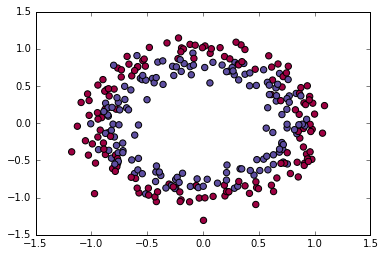

In [59]:
# X, y = generate_data();
X, y = gen_data();
hoty = to_one_hot(y)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
# plt.savefig("data.eps", format = "eps");
plt.savefig("circle.eps", format = "eps")
plt.show();

In [61]:
# print "Input Dim:", X.shape
# print "Output Dim:", y.shape
net = make_net(2, [4, 4], 2);
feedforward(net, X);
# print_net(net);
# print net["a"][-1]
train(net, X, hoty, 0.01);
pred = predict(net, X)

Loss at epoch 19000: 0.164496
Loss at epoch 18000: 0.144145
Loss at epoch 17000: 0.204974
Loss at epoch 16000: 0.198740
Loss at epoch 15000: 0.205149
Loss at epoch 14000: 0.228704
Loss at epoch 13000: 0.174982
Loss at epoch 12000: 0.197517
Loss at epoch 11000: 0.146644
Loss at epoch 10000: 0.176655
Loss at epoch 9000: 0.158118
Loss at epoch 8000: 0.143002
Loss at epoch 7000: 0.184463
Loss at epoch 6000: 0.084152
Loss at epoch 5000: 0.190229
Loss at epoch 4000: 0.199728
Loss at epoch 3000: 0.163257
Loss at epoch 2000: 0.189188
Loss at epoch 1000: 0.193707
Loss at epoch 0: 0.010430


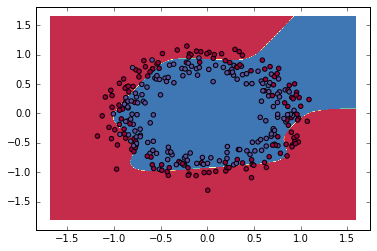

In [62]:
visualize(net, X, y)